In [31]:
%pylab inline
import os, sys, glob, json, math
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F

# %load_ext autoreload
# %autoreload 2
# pd.set_option('display.max_colwidth', -1)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

In [4]:
import torch
from transformers import (
    BertModel,
    BertTokenizer
)

In [5]:
# Instantiate a tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load and convert test data

In [6]:
# Read in test data
data_test = pd.read_csv('data/labelled_test.csv', index_col=0)

In [9]:
data_test.label.value_counts()

E    112
F    111
O     91
T     90
Name: label, dtype: int64

In [10]:
data_test

,sentence,label,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,sentence_length,target
927,.We visited mid-morning and used the fast trac...,O,697435564.0,294497.0,Hagia Sophia Museum / Church (Ayasofya),293974,Istanbul,22718.0,5.0,1.0,Favourite site in Istanbul,13.0,2
217,There are also many paintings by artists I had...,E,619368814.0,188862.0,National Gallery,186338,London,22571.0,5.0,1.0,"Surprisingly good, well worth a visit",18.0,0
773,In most cases the presidents only vaguely rese...,F,454557337.0,143395.0,Magic Kingdom Park,34515,Orlando,42831.0,2.0,10.0,Magic is gone,14.0,1
1544,".For those of us who hydrate healthy, bring nu...",T,653504441.0,143394.0,Walt Disney World Resort,34515,Orlando,23357.0,1.0,35.0,Da MOUSE be makin' DAT Money!,11.0,3
2690,The Jurassic Park River Adventure was fun.,E,454129851.0,258685.0,Universal's Islands of Adventure,34515,Orlando,33390.0,5.0,2.0,Wore Us Out,7.0,0
1261,They dive off the lighthouse in the middle of ...,E,577807215.0,207144.0,LEGOLAND Windsor Resort,186419,Windsor,31630.0,4.0,5.0,Novice Family weekend,16.0,0
3633,"More than two dozen rides await you, in additi...",F,NaN,NaN,NaN,189541,Copenhagen,NaN,NaN,NaN,NaN,NaN,1
2345,"The Egyptian, Roman, and Greek displays are to...",E,18710612.0,187555.0,The British Museum,186338,London,41623.0,5.0,4.0,Wow!,9.0,0
578,.Fast passes should be free like they are at D...,T,122922847.0,102432.0,Universal Studios Florida,34515,Orlando,36375.0,1.0,20.0,Outrageously Expensive and Poorly Run,11.0,3
2527,".Coincidentally, there was a separate exhibiti...",O,609423627.0,191025.0,Kilmainham Gaol,186605,Dublin,22042.0,4.0,2.0,A much improved tourist attraction,14.0,2


In [11]:
from transformers.data.processors.utils import InputExample
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler



# Contruct InputExample
test_examples = [InputExample(guid=i,
                            text_a=text,
                            label=target) for i, text, target in zip(data_test.index.tolist(), data_test.sentence.tolist(), data_test.target.tolist())]
max_length = 128

# Construct features
features_test = convert_examples_to_features(test_examples,
                                        tokenizer,
                                        label_list=list(range(4)), # Since we have 4 classes
                                        max_length=max_length,
                                        output_mode='classification',
                                        pad_on_left=False,
                                        pad_token=tokenizer.pad_token_id,
                                        pad_token_segment_id=0)

In [20]:
# Contruct TensorDataset
test_dataset = TensorDataset(torch.tensor(data_test.index.tolist(), dtype=torch.long),
                              torch.tensor([f.input_ids for f in features_test], dtype=torch.long), 
                              torch.tensor([f.attention_mask for f in features_test], dtype=torch.long), 
                              torch.tensor([f.token_type_ids for f in features_test], dtype=torch.long), 
                              torch.tensor([f.label for f in features_test], dtype=torch.long))

# Construct DataLoader
eval_sampler_test = SequentialSampler(test_dataset)
eval_dataloader_test = DataLoader(test_dataset, sampler=eval_sampler_test, batch_size=32)

In [22]:
for index, i, a, t, l in eval_dataloader_test:
    print(index)
    print(i)
    print(a)
    print(t)
    print(l)
    break

tensor([ 927,  217,  773, 1544, 2690, 1261, 3633, 2345,  578, 2527, 3463, 2044,
        1077, 3511, 3817, 1276, 3432, 3506, 1732, 3764, 1424,  955, 3284, 1259,
        2132, 1494, 3436, 3035, 2515,  502, 3370, 2720])
tensor([[ 101, 1012, 2057,  ...,    0,    0,    0],
        [ 101, 2045, 2024,  ...,    0,    0,    0],
        [ 101, 1999, 2087,  ...,    0,    0,    0],
        ...,
        [ 101, 1012, 2004,  ...,    0,    0,    0],
        [ 101, 7523, 1996,  ...,    0,    0,    0],
        [ 101, 2009, 2001,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([2, 0, 1, 3, 0

## Define model

In [24]:
class BERTSequenceClassifier1FC(nn.Module):
    def __init__(self, num_classes, freeze_bert=True):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        # Freeze all weights in bert if freeze_bert is True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.num_classes = num_classes
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        h, _, attn = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask, 
                               token_type_ids=token_type_ids)
        h_cls = h[:, 0] # 0 means take h_cls only
        logits = self.classifier(h_cls)
        return logits, attn

In [43]:
from transformers import glue_compute_metrics as compute_metrics
from sklearn.metrics import accuracy_score

# Start evaluating

indices = []
y_pred = []
y_true = []

frozen = False

model_eval = BERTSequenceClassifier1FC(4)
state_dict_path = 'model/bert_fine_tuned/unfrozen_1_layer_after_3_epoch_1102.pt'
if frozen:
    model_eval.classifier.load_state_dict(torch.load(state_dict_path))
else:
    model_eval.load_state_dict(torch.load(state_dict_path))
# print('Loaded model trained after {} epochs'.format(i + 1))

for index, i, a, t, l in tqdm(eval_dataloader_test, desc="Evaluating"):
    
    model_eval.eval()
#     batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        logits, attn = model_eval(i, a, t)
        prob_pred = F.softmax(logits, dim=1)
        indices.extend(index.view(-1).tolist())
        y_true.extend(l.view(-1).tolist())
        y_pred.extend(prob_pred.tolist())
#         eval_loss += criterion(logits.view(-1, model_eval.num_classes), labels.view(-1)).mean().item()

#     nb_eval_steps += 1
#     preds_temp.append(logits.view(-1, model_eval.num_classes).detach().cpu())
    
#     all_labels_temp.append(labels.view(-1).detach().cpu())

# eval_loss = eval_loss / nb_eval_steps

# preds = torch.cat(preds_temp, 0).numpy()
# preds = np.argmax(preds, axis=1)

# all_labels = torch.cat(all_labels_temp, 0).numpy()

# preds_test[i] = preds.copy()
# all_labels_test[i] = all_labels.copy()
# acc_temp = accuracy_score(all_labels, preds)
# # Print accuracy
# print('Using model trained after {} epochs, test accuracy is {}'.format(i + 1, acc_temp))
# acc_test.append(acc_temp)

Evaluating: 100%|██████████| 13/13 [00:44<00:00,  3.03s/it]


In [49]:
y_pred

[[0.003260955912992358,
  0.005506075918674469,
  0.8074943423271179,
  0.18373863399028778],
 [0.7750474810600281,
  0.13436183333396912,
  0.029803216457366943,
  0.06078742817044258],
 [0.07290290296077728,
  0.7656731009483337,
  0.15173830091953278,
  0.009685727767646313],
 [0.0008422639220952988,
  0.01079624705016613,
  0.004126918967813253,
  0.984234631061554],
 [0.9802367091178894,
  0.0034490872640162706,
  0.014234162867069244,
  0.0020800847560167313],
 [0.9357209205627441,
  0.0035260915756225586,
  0.05709781125187874,
  0.003655213862657547],
 [0.00043921402539126575,
  0.9923545122146606,
  0.001022899174131453,
  0.00618335185572505],
 [0.9545618295669556,
  0.039643801748752594,
  0.004623528104275465,
  0.0011709490790963173],
 [0.0032337973825633526,
  0.007312300615012646,
  0.017260823398828506,
  0.9721931219100952],
 [0.00288941478356719,
  0.9421776533126831,
  0.03279225528240204,
  0.022140663117170334],
 [0.02093866840004921,
  0.44160082936286926,
  0.005

In [52]:
np.array(y_pred)[:, 0]

array([3.26095591e-03, 7.75047481e-01, 7.29029030e-02, 8.42263922e-04,
       9.80236709e-01, 9.35720921e-01, 4.39214025e-04, 9.54561830e-01,
       3.23379738e-03, 2.88941478e-03, 2.09386684e-02, 2.27682432e-03,
       8.47923756e-01, 4.24738915e-04, 3.66354448e-04, 7.38169789e-01,
       1.59336918e-03, 1.52226421e-03, 2.07244251e-02, 1.16045377e-03,
       9.86495614e-01, 6.33730173e-01, 9.78186843e-04, 9.83350396e-01,
       7.57467095e-03, 2.18759641e-01, 1.41462922e-01, 1.19803064e-01,
       8.17656457e-01, 1.03214663e-03, 8.49906995e-04, 5.73040664e-01,
       9.74615574e-01, 6.95419312e-01, 1.86973184e-01, 9.88848686e-01,
       9.44168091e-01, 2.18569720e-03, 2.02520448e-03, 2.19210028e-03,
       2.78617889e-02, 9.73660707e-01, 7.69771810e-04, 2.55621667e-03,
       1.02507155e-02, 9.88556743e-01, 1.63545124e-02, 1.03728011e-01,
       9.71432030e-03, 6.98295247e-04, 3.35266367e-02, 1.62006076e-03,
       4.79477691e-03, 3.04953575e-01, 5.03033912e-03, 1.59687195e-02,
      

## ROC on Test Set

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

In [57]:
# List ot numpy array
indices = np.array(indices)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

### Plot

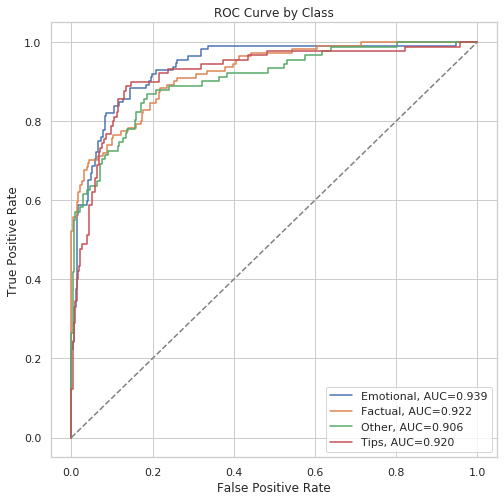

In [84]:
labels_list = ['Emotional', 'Factual', 'Other', 'Tips']

fig, ax = plt.subplots(figsize=(8, 8))

for i, name in enumerate(labels_list):
    y_true_temp = (y_true == i).astype(int)
    y_prob_temp = y_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_true_temp, y_prob_temp)
    auc = roc_auc_score(y_true_temp, y_prob_temp)
    # Plot the ROC curve
    ax.plot(fpr, tpr, label='{}, AUC={:.3f}'.format(name, auc))
    
ax.plot((0, 1), (0, 1), '--', color='grey')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve by Class')

plt.show()